In [7]:
!pip install -q kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
distutils: /opt/conda/include/python3.8/UNKNOWN
sysconfig: /opt/conda/include/python3.8
user = False
home = None
root = None
prefix = None
Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


In [24]:
# !mv /home/jovyan/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2 /home/jovyan/

In [49]:
from glob import glob
dir = './2'
imgs = sorted(glob(dir+'/**/*.jpg',recursive = True))
# imgs

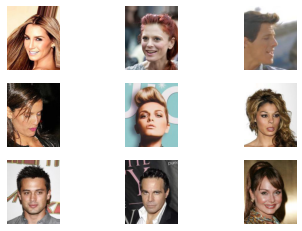

In [50]:
from PIL import Image
import matplotlib.pyplot as plt
for i in range(9):
    plt.subplot(3,3,i+1)
    img = Image.open(imgs[i])
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
# 이미지는 항상 조심 : 사이즈가 다 다르다... 채널정보가 다를수도 있음
# 이미지 전처리 : 크기통일, 텐서, 정규화(각 채널별 평균은 0.5 , 표준편차는 0.2) , 채널정보 GrayScale 적용

In [51]:
import torch
import torchvision.transforms as tf
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

transforms = tf.Compose([
    tf.Resize(64),
    tf.CenterCrop(64),
    tf.ToTensor(),
    tf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = ImageFolder(
    root = "/home/jovyan/2/img_align_celeba/",
    transform=transforms
)
loader = DataLoader(dataset, batch_size = 128, shuffle=True)

In [86]:
import torch.nn as nn
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 생성자를 구성하는 총 정의
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(100,512,kernel_size=4, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
            nn.Tanh()
        )
    def forward(self, x):
        return self.gen(x)

In [87]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 감별자 구성 층 정의
        self.disc = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(512,1,kernel_size=4),
            nn.Sigmoid()
            
    )
    def forward(self, x):
        return self.disc(x)

In [88]:
# GAN의 학습을 원활하게 이루어지도록 가중치 초기화 설정
def weights_init(m):
    # 층의 종류 추출
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # 합성곱 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        # 배치 정규화층 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [89]:
import tqdm
from torch.optim.adam import Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [90]:
# 생성자 정의
G = Generator().to(device)
G.apply(weights_init)

# 감별자 정의
D = Discriminator().to(device)
D.apply(weights_init)

G_optim = Adam(G.parameters(),lr=0.0001, betas=(0.5, 0.999))
D_optim = Adam(D.parameters(),lr=0.0001, betas=(0.5, 0.999))

In [ ]:
import os
best_loss = float('inf')
for epochs in range(50):
    iterator = tqdm.tqdm(enumerate(loader,0),total=len(loader))
    
    for i, data in iterator:
        D_optim.zero_grad()
        # 실제 이미지 1, 생성 이미지 0으로 정답 설정
        label = torch.ones_like(data[1], dtype=torch.float32).to(device)
        label_fake = torch.zeros_like(data[1], dtype=torch.float32).to(device)
        # 실제 이미지를 감별자에 입력
        real = D(data[0].to(device))
        # 실제 이미지에 대한 감별자의 오차 계산
        Dloss_real = nn.BCELoss()(torch.squeeze(real), label)
        Dloss_real.backward()
        
        # 감별자 학습
        # 가짜 이미지 생성
        noise = torch.randn(label.shape[0], 100, 1, 1, device=device)
        fake = G(noise)
        # 가짜 이미지를 감별자에 입력
        output = D(fake.detach())
        
        # 가짜 이미지에 대한 감별자의 오차 계산
        Dloss_fake = nn.BCELoss()(torch.squeeze(output), label_fake)
        Dloss_fake.backward()
        
        # 감별자의 전체 오차를 학습
        Dloss = 0.5 * (Dloss_real + Dloss_fake)
        D_optim.step()
        
        # 생성자의 학습
        G_optim.zero_grad()
        output = D(fake)
        Gloss = nn.BCELoss()(torch.squeeze(output),label)
        Gloss.backward()
        
        G_optim.step()
        
        iterator.set_description(f'epoch:{epochs} iteration:{i+1} D_loss:{Dloss} Gloss:{Gloss}')
        
        if Gloss.item() < best_loss:
            best_loss = Gloss.item()
            torch.save(G.state_dict(), 'Generator.pth')
            torch.save(D.state_dict(), 'Discriminator.pth')
            print(f"Best model saved at epoch {epochs}, batch {i+1} with G loss: {Gloss.item()} and D loss: {Dloss.item()}")
        

epoch:0 iteration:1 D_loss:0.286490797996521 Gloss:3.9403645992279053:   0%|          | 1/1583 [00:00<09:26,  2.79it/s]

Best model saved at epoch 0, batch 1 with G loss: 3.9403645992279053 and D loss: 0.286490797996521


epoch:0 iteration:219 D_loss:0.015806585550308228 Gloss:9.024421691894531:  14%|█▍        | 219/1583 [00:59<06:02,  3.76it/s] 

In [95]:
print(type(G))  # Ensure this is torch.nn.Module
print(type(G_optim))  # Ensure this is torch.optim.Optimizer

<class '__main__.Generator'>
<class 'torch.optim.adam.Adam'>
